<a href="https://colab.research.google.com/github/sauravsb99/Pulmonary-Fibrosis/blob/main/osic_autoencoder_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. OSIC AutoEncoder training
This notebooks demonstrates how to train a convolutional AutoEncoder to learn latent features from the 3D CT scans dataset.

One of the main applications of AutoEncoders is dimensionality reduction. We will use them for that: reducing 3D images (preprocessed to 1 x 40 x 256 x 256 tensors) to vectors (with 10 dimensions).
![autoencoder](https://hackernoon.com/hn-images/1*8ixTe1VHLsmKB3AquWdxpQ.png)

Once we have the trained model, the idea is to apply it to extract these latent features and combine them with the OSIC tabular data.

My first experiments had a less strangled bottleneck (started with 96 x 2 x 20 x 20), which was already a reduction of over 34:1 (the inputs are 3D images of 1 x 40 x 256 x 256). The AutoEncoder output was great, easy to see. However, using latent features of 96 x 2 x 20 x 20 meant that, in the tabular model, I had to combine 76,800 features (flattened) with the 9 tabular features. In order to have a better balance between tabular and latent features, I decide to strangle the bottleneck further, squeezing the 3D images to 10 features (already flatenned in the AutoEncoder model). As you can see below, the model learns as the loss keeps going down. However, the output of the AutoEncoder is not as visible as with the less strangled bottleneck.

# 2. Imports and global variables

In [1]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 9.3MB/s 


In [2]:
import copy
from datetime import timedelta, datetime
import imageio
import matplotlib.pyplot as plt
from matplotlib import cm
import multiprocessing
import numpy as np
import os
from pathlib import Path
import pydicom
import pytest
import scipy.ndimage as ndimage
from scipy.ndimage.interpolation import zoom
from skimage import measure, morphology, segmentation
from time import time, sleep
from tqdm import trange, tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DistributedSampler, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import warnings

In [4]:
!pwd

/content


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "/content/drive/My Drive/PulmonaryFibrosis/archive.zip" -d "/content/osic-cached-dataset/"

Archive:  /content/drive/My Drive/PulmonaryFibrosis/archive.zip
  inflating: /content/osic-cached-dataset/ID00007637202177411956430.pt  
  inflating: /content/osic-cached-dataset/ID00009637202177434476278.pt  
  inflating: /content/osic-cached-dataset/ID00010637202177584971671.pt  
  inflating: /content/osic-cached-dataset/ID00011637202177653955184.pt  
  inflating: /content/osic-cached-dataset/ID00012637202177665765362.pt  
  inflating: /content/osic-cached-dataset/ID00014637202177757139317.pt  
  inflating: /content/osic-cached-dataset/ID00015637202177877247924.pt  
  inflating: /content/osic-cached-dataset/ID00019637202178323708467.pt  
  inflating: /content/osic-cached-dataset/ID00020637202178344345685.pt  
  inflating: /content/osic-cached-dataset/ID00023637202179104603099.pt  
  inflating: /content/osic-cached-dataset/ID00025637202179541264076.pt  
  inflating: /content/osic-cached-dataset/ID00026637202179561894768.pt  
  inflating: /content/osic-cached-dataset/ID0002763720217968

In [5]:
!unzip "/content/drive/My Drive/PulmonaryFibrosis/PulmonaryFibrosis.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/ID00370637202296737666151/139.dcm  
  inflating: train/ID00370637202296737666151/14.dcm  
  inflating: train/ID00370637202296737666151/140.dcm  
  inflating: train/ID00370637202296737666151/141.dcm  
  inflating: train/ID00370637202296737666151/142.dcm  
  inflating: train/ID00370637202296737666151/143.dcm  
  inflating: train/ID00370637202296737666151/144.dcm  
  inflating: train/ID00370637202296737666151/145.dcm  
  inflating: train/ID00370637202296737666151/146.dcm  
  inflating: train/ID00370637202296737666151/147.dcm  
  inflating: train/ID00370637202296737666151/148.dcm  
  inflating: train/ID00370637202296737666151/149.dcm  
  inflating: train/ID00370637202296737666151/15.dcm  
  inflating: train/ID00370637202296737666151/150.dcm  
  inflating: train/ID00370637202296737666151/151.dcm  
  inflating: train/ID00370637202296737666151/152.dcm  
  inflating: train/ID00370637202296737666151/153.dcm  
  inflating: tra

In [3]:
!ls


drive  sample_data  sample_submission.csv  test  test.csv  train  train.csv


In [6]:
!cp -r "/content/drive/My Drive/PulmonaryFibrosis/test" "/content/"

In [15]:
drive.flush_and_unmount()



In [17]:
!rm sample_submission.csv





In [18]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          69G   49G   21G  71% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
tmpfs           6.4G   24K  6.4G   1% /var/colab
/dev/sda1        75G   70G  4.9G  94% /opt/bin
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            69G   50G   20G  72% /content/drive


In [7]:
root_dir = '/content/osic-cached-dataset'
# train_dir = '/content/train'
test_dir = '/content/test'
model_file = '/content/working/diophantus.pt'
resize_dims = (40, 256, 256)
clip_bounds = (-1000, 200)
watershed_iterations = 1
pre_calculated_mean = 0.02865046213070556
latent_features = 10
batch_size = 16
learning_rate = 3e-5
num_epochs = 10
val_size = 0.2
tensorboard_dir = '/content/working/runs'

# 3. Dataset interface

## 3.1. ctscans_dataset.py
This interface ingests the data from the 3D CT scans, porting them to a PyTorch Dataset.**

In [8]:
class CTScansDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.patients = [p for p in self.root_dir.glob('*') if p.is_dir()]
        self.transform = transform

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image, metadata = self.load_scan(self.patients[idx])
        sample = {'image': image, 'metadata': metadata}
        if self.transform:
            sample = self.transform(sample)

        return sample

    def save(self, path):
        t0 = time()
        Path(path).mkdir(exist_ok=True, parents=True)
        print('Saving pre-processed dataset to disk')
        sleep(1)
        cum = 0

        bar = trange(len(self))
        for i in bar:
            sample = self[i]
            image, data = sample['image'], sample['metadata']
            cum += torch.mean(image).item()

            bar.set_description(f'Saving CT scan {data.PatientID}')
            fname = Path(path) / f'{data.PatientID}.pt'
            torch.save(image, fname)

        sleep(1)
        bar.close()
        print(f'Done! Time {timedelta(seconds=time() - t0)}\n'
              f'Mean value: {cum / len(self)}')

    def get_patient(self, patient_id):
        patient_ids = [str(p.stem) for p in self.patients]
        return self.__getitem__(patient_ids.index(patient_id))

    @staticmethod
    def load_scan(path):
        slices = [pydicom.read_file(p) for p in path.glob('*.dcm')]
        try:
            slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
        except AttributeError:
            warnings.warn(f'Patient {slices[0].PatientID} CT scan does not '
                          f'have "ImagePositionPatient". Assuming filenames '
                          f'in the right scan order.')

        image = np.stack([s.pixel_array.astype(float) for s in slices])
        return image, slices[0]

## 3.2. Pre-processing
There are some pre-processing to be done. Let's tackle them one step at a time.
### 3.2.1. crop_bounding_box.py

In [9]:
class CropBoundingBox:
    @staticmethod
    def bounding_box(img3d: np.array):
        mid_img = img3d[int(img3d.shape[0] / 2)]
        same_first_row = (mid_img[0, :] == mid_img[0, 0]).all()
        same_first_col = (mid_img[:, 0] == mid_img[0, 0]).all()
        if same_first_col and same_first_row:
            return True
        else:
            return False

    def __call__(self, sample):
        image, data = sample['image'], sample['metadata']
        if not self.bounding_box(image):
            return sample

        mid_img = image[int(image.shape[0] / 2)]
        r_min, r_max = None, None
        c_min, c_max = None, None
        for row in range(mid_img.shape[0]):
            if not (mid_img[row, :] == mid_img[0, 0]).all() and r_min is None:
                r_min = row
            if (mid_img[row, :] == mid_img[0, 0]).all() and r_max is None \
                    and r_min is not None:
                r_max = row
                break

        for col in range(mid_img.shape[1]):
            if not (mid_img[:, col] == mid_img[0, 0]).all() and c_min is None:
                c_min = col
            if (mid_img[:, col] == mid_img[0, 0]).all() and c_max is None \
                    and c_min is not None:
                c_max = col
                break

        image = image[:, r_min:r_max, c_min:c_max]
        return {'image': image, 'metadata': data}

### 3.2.2. convert_to_hu.py
Credits to [Guido Zuidhof's tutorial](https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial).

In [10]:
class ConvertToHU:
    def __call__(self, sample):
        image, data = sample['image'], sample['metadata']

        img_type = data.ImageType
        is_hu = img_type[0] == 'ORIGINAL' and not (img_type[2] == 'LOCALIZER')
        # if not is_hu:
        #     warnings.warn(f'Patient {data.PatientID} CT Scan not cannot be'
        #                   f'converted to Hounsfield Units (HU).')

        intercept = data.RescaleIntercept
        slope = data.RescaleSlope
        image = (image * slope + intercept).astype(np.int16)
        return {'image': image, 'metadata': data}

### 3.2.3. resize.py

In [11]:
class Resize:
    def __init__(self, output_size):
        assert isinstance(output_size, tuple)
        self.output_size = output_size

    def __call__(self, sample):
        image, data = sample['image'], sample['metadata']
        resize_factor = np.array(self.output_size) / np.array(image.shape)
        image = zoom(image, resize_factor, mode='nearest')
        return {'image': image, 'metadata': data}

### 3.2.4. clip.py

In [12]:
class Clip:
    def __init__(self, bounds=(-1000, 500)):
        self.min = min(bounds)
        self.max = max(bounds)

    def __call__(self, sample):
        image, data = sample['image'], sample['metadata']
        image[image < self.min] = self.min
        image[image > self.max] = self.max
        return {'image': image, 'metadata': data}

### 3.2.5. mask_watershed.py
Credits to [Aadhav Vignesh's amazing kernel](https://www.kaggle.com/aadhavvignesh/lung-segmentation-by-marker-controlled-watershed).

IMPORTANT: I made some changes in Vignesh's code below to make it scalable, most notably reducing the number of iterations from 8 to 1. This was important to reduce the time to generate masks from ~8-9 seconds/slice (which would take over 17 hours to complete) to ~100ms/slice. I'm satisfied with the quality of the masks, as you can see in some samples below. However, using 8 iterations generate even better masks.

In [13]:
class MaskWatershed:
    def __init__(self, min_hu, iterations, show_tqdm):
        self.min_hu = min_hu
        self.iterations = iterations
        self.show_tqdm = show_tqdm

    def __call__(self, sample):
        image, data = sample['image'], sample['metadata']

        stack = []
        if self.show_tqdm:
            bar = trange(image.shape[0])
            bar.set_description(f'Masking CT scan {data.PatientID}')
        else:
            bar = range(image.shape[0])
        for slice_idx in bar:
            sliced = image[slice_idx]
            stack.append(self.seperate_lungs(sliced, self.min_hu,
                                             self.iterations))

        return {
            'image': np.stack(stack),
            'metadata': sample['metadata']
        }

    @staticmethod
    def seperate_lungs(image, min_hu, iterations):
        h, w = image.shape[0], image.shape[1]

        marker_internal, marker_external, marker_watershed = MaskWatershed.generate_markers(image)

        # Sobel-Gradient
        sobel_filtered_dx = ndimage.sobel(image, 1)
        sobel_filtered_dy = ndimage.sobel(image, 0)
        sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
        sobel_gradient *= 255.0 / np.max(sobel_gradient)

        watershed = morphology.watershed(sobel_gradient, marker_watershed)

        outline = ndimage.morphological_gradient(watershed, size=(3,3))
        outline = outline.astype(bool)

        # Structuring element used for the filter
        blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                           [0, 1, 1, 1, 1, 1, 0],
                           [1, 1, 1, 1, 1, 1, 1],
                           [1, 1, 1, 1, 1, 1, 1],
                           [1, 1, 1, 1, 1, 1, 1],
                           [0, 1, 1, 1, 1, 1, 0],
                           [0, 0, 1, 1, 1, 0, 0]]

        blackhat_struct = ndimage.iterate_structure(blackhat_struct, iterations)

        # Perform Black Top-hat filter
        outline += ndimage.black_tophat(outline, structure=blackhat_struct)

        lungfilter = np.bitwise_or(marker_internal, outline)
        lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)

        segmented = np.where(lungfilter == 1, image, min_hu * np.ones((h, w)))

        return segmented  #, lungfilter, outline, watershed, sobel_gradient

    @staticmethod
    def generate_markers(image, threshold=-400):
        h, w = image.shape[0], image.shape[1]

        marker_internal = image < threshold
        marker_internal = segmentation.clear_border(marker_internal)
        marker_internal_labels = measure.label(marker_internal)

        areas = [r.area for r in measure.regionprops(marker_internal_labels)]
        areas.sort()

        if len(areas) > 2:
            for region in measure.regionprops(marker_internal_labels):
                if region.area < areas[-2]:
                    for coordinates in region.coords:
                        marker_internal_labels[coordinates[0], coordinates[1]] = 0

        marker_internal = marker_internal_labels > 0

        # Creation of the External Marker
        external_a = ndimage.binary_dilation(marker_internal, iterations=10)
        external_b = ndimage.binary_dilation(marker_internal, iterations=55)
        marker_external = external_b ^ external_a

        # Creation of the Watershed Marker
        marker_watershed = np.zeros((h, w), dtype=np.int)
        marker_watershed += marker_internal * 255
        marker_watershed += marker_external * 128

        return marker_internal, marker_external, marker_watershed

### 3.2.6. normalize.py, to_tensor.py, zero_center.py

In [14]:
class Normalize:
    def __init__(self, bounds=(-1000, 500)):
        self.min = min(bounds)
        self.max = max(bounds)

    def __call__(self, sample):
        image, data = sample['image'], sample['metadata']
        image = image.astype(np.float)
        image = (image - self.min) / (self.max - self.min)
        return {'image': image, 'metadata': data}
    

class ToTensor:
    def __init__(self, add_channel=True):
        self.add_channel = add_channel

    def __call__(self, sample):
        image, data = sample['image'], sample['metadata']
        if self.add_channel:
            image = np.expand_dims(image, axis=0)

        return {'image': torch.from_numpy(image), 'metadata': data}
    
    
class ZeroCenter:
    def __init__(self, pre_calculated_mean):
        self.pre_calculated_mean = pre_calculated_mean

    def __call__(self, tensor):
        return tensor - self.pre_calculated_mean

### 3.2.7. Inspecting some slices

In [15]:
def show(list_imgs, cmap=cm.bone):
    list_slices = []
    for img3d in list_imgs:
        slc = int(img3d.shape[0] / 2)
        img = img3d[slc]
        list_slices.append(img)
    
    fig, axs = plt.subplots(1, 5, figsize=(15, 7))
    for i, img in enumerate(list_slices):
        axs[i].imshow(img, cmap=cmap)
        axs[i].axis('off')
        
    plt.show()

Masking CT scan ID00426637202313170790466: 100%|██████████| 40/40 [00:03<00:00, 11.70it/s]


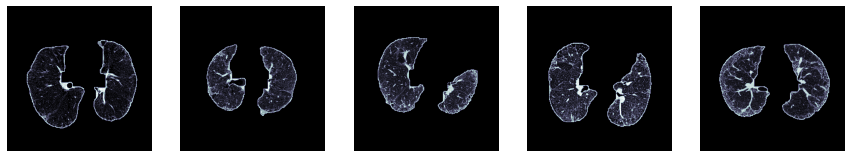

In [16]:
test = CTScansDataset(
    root_dir=test_dir,
    transform=transforms.Compose([
        CropBoundingBox(),
        ConvertToHU(),
        Resize(resize_dims),
        Clip(bounds=clip_bounds),
        MaskWatershed(min_hu=min(clip_bounds), iterations=1, show_tqdm=True),
        Normalize(bounds=clip_bounds)
    ]))

list_imgs = [test[i]['image'] for i in range(len(test))]
show(list_imgs)

## 3.3. Caching pre-processed images in the disk
Pre-processing all 176 3D CT scans take some time. Depending on the parameters we choose, it can take hours. 

With the current choice of parameters, it takes around 15 minutes. To accelerate experimentation, I already pre-cached the images with the preprocessing parameters in this notebook, saving them in a [public dataset](https://www.kaggle.com/carlossouza/osic-cached-dataset). 

This way, you can preprocess only once, and experiment with the same preprocessed tensors. The code to preprocess and cache images in the disk is:
```
data = CTScansDataset(
    root_dir=root_dir,
    transform=transforms.Compose([
        CropBoundingBox(),
        ConvertToHU(),
        Resize(size),
        Clip(bounds=clip_bounds),
        MaskWatershed(
            min_hu=min(clip_bounds),
            iterations=watershed_iterations,
            show_tqdm=False),
        Normalize(bounds=clip_bounds),
        ToTensor()
    ]))
data.save(dest_dir)
```

From this point on, we use the `CTTensorsDataset` as the interface to ingest the preprocessed tensors, taking the data to training.

In [27]:
dest_dir = root_dir
data = CTScansDataset(
    root_dir=train_dir,
    transform=transforms.Compose([
        CropBoundingBox(),
        ConvertToHU(),
        Resize(resize_dims),
        Clip(bounds=clip_bounds),
        MaskWatershed(
            min_hu=min(clip_bounds),
            iterations=watershed_iterations,
            show_tqdm=False),
        Normalize(bounds=clip_bounds),
        ToTensor()
    ]))
data.save(dest_dir)

Saving pre-processed dataset to disk



Saving CT scan ID00378637202298597306391:  19%|█▉        | 33/176 [07:57<43:05, 18.08s/it]

RuntimeError: ignored

In [28]:
!rm -r osic-cached-dataset



In [17]:
class CTTensorsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.tensor_files = sorted([f for f in self.root_dir.glob('*.pt')])
        self.transform = transform

    def __len__(self):
        return len(self.tensor_files)

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.tolist()

        image = torch.load(self.tensor_files[item])
        if self.transform:
            image = self.transform(image)

        return {
            'patient_id': self.tensor_files[item].stem,
            'image': image
        }

    def mean(self):
        cum = 0
        for i in range(len(self)):
            sample = self[i]['image']
            cum += torch.mean(sample).item()

        return cum / len(self)

    def random_split(self, val_size: float):
        num_val = int(val_size * len(self))
        num_train = len(self) - num_val
        return random_split(self, [num_train, num_val])

### 3.3.1. Checking data pipeline

In [18]:
train = CTTensorsDataset(
    root_dir=root_dir,
    transform=ZeroCenter(pre_calculated_mean=pre_calculated_mean)
)
cum = 0
for i in range(len(train)):
    sample = train[i]['image']
    cum += torch.mean(sample).item()

assert cum / len(train) == pytest.approx(0)

# 4. AutoEncoder
Credits to [Srinjay Paul's great tutorial](https://srinjaypaul.github.io/3D_Convolutional_autoencoder_for_brain_volumes/), and lots of papers (I will link them later).

As mentioned, I strangled the bottleneck to force very few latent features (10). The image below shows the transformations:
![autoencoder](https://i.ibb.co/2hYZFc1/autoencoder.jpg)

In [19]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_features=latent_features):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.conv1 = nn.Conv3d(1, 16, 3)
        self.conv2 = nn.Conv3d(16, 32, 3)
        self.conv3 = nn.Conv3d(32, 96, 2)
        self.conv4 = nn.Conv3d(96, 1, 1)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.pool2 = nn.MaxPool3d(kernel_size=3, stride=3, return_indices=True)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.fc1 = nn.Linear(10 * 10, latent_features)
        # Decoder
        self.fc2 = nn.Linear(latent_features, 10 * 10)
        self.deconv0 = nn.ConvTranspose3d(1, 96, 1)
        self.deconv1 = nn.ConvTranspose3d(96, 32, 2)
        self.deconv2 = nn.ConvTranspose3d(32, 16, 3)
        self.deconv3 = nn.ConvTranspose3d(16, 1, 3)
        self.unpool0 = nn.MaxUnpool3d(kernel_size=2, stride=2)
        self.unpool1 = nn.MaxUnpool3d(kernel_size=2, stride=2)
        self.unpool2 = nn.MaxUnpool3d(kernel_size=3, stride=3)
        self.unpool3 = nn.MaxUnpool3d(kernel_size=2, stride=2)

    def encode(self, x, return_partials=True):
        # Encoder
        x = self.conv1(x)
        up3out_shape = x.shape
        x, i1 = self.pool1(x)

        x = self.conv2(x)
        up2out_shape = x.shape
        x, i2 = self.pool2(x)

        x = self.conv3(x)
        up1out_shape = x.shape
        x, i3 = self.pool3(x)

        x = self.conv4(x)
        up0out_shape = x.shape
        x, i4 = self.pool4(x)

        x = x.view(-1, 10 * 10)
        x = F.relu(self.fc1(x))

        if return_partials:
            return x, up3out_shape, i1, up2out_shape, i2, up1out_shape, i3, \
                   up0out_shape, i4

        else:
            return x

    def forward(self, x):
        x, up3out_shape, i1, up2out_shape, i2, \
        up1out_shape, i3, up0out_shape, i4 = self.encode(x)

        # Decoder
        x = F.relu(self.fc2(x))
        x = x.view(-1, 1, 1, 10, 10)
        x = self.unpool0(x, output_size=up0out_shape, indices=i4)
        x = self.deconv0(x)
        x = self.unpool1(x, output_size=up1out_shape, indices=i3)
        x = self.deconv1(x)
        x = self.unpool2(x, output_size=up2out_shape, indices=i2)
        x = self.deconv2(x)
        x = self.unpool3(x, output_size=up3out_shape, indices=i1)
        x = self.deconv3(x)

        return x

# 5. Training
I decided to take this opportunity to learn how to use TPUs. However, after days of intense frustration, I gave up. XLA documentation is very poor. Notebook examples are either so simple they are not useful at all, or so advanced/complex it is impossible to understand what is happening. The code frequently freezes, and it is impossible to know what is happening in the background…

The code below runs smoothly on GPU.

## 5.1. Monitoring on Tensorboard
Credits to [Shivam Kumar tutorial](https://www.kaggle.com/shivam1600/tensorboard-on-kaggle).

In [20]:
!rm -rf ./logs/ 
!mkdir ./logs/
# Download Ngrok to tunnel the tensorboard port to an external port
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
pool = multiprocessing.Pool(processes = 10)
results_of_processes = [
    pool.apply_async(os.system, args=(cmd, ), callback=None) for cmd in [
        f"tensorboard --logdir {tensorboard_dir}/ --host 0.0.0.0 --port 6006 &",
        "./ngrok http 6006 &"
    ]
]

--2021-04-24 10:15:05--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.209.27.98, 3.222.61.237, 52.5.194.13, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.209.27.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13828408 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  18.6MB/s    in 0.7s    

2021-04-24 10:15:06 (18.6 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13828408/13828408]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [21]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://f06a2533e4bc.ngrok.io


## 5.2. Training loop
IMPORTANT: For the sake of the demonstration, I'm running this training only for 10 epochs. To have usable results, we need at least 100 epochs.

In [22]:
t0 = time()

# Load the data
data = CTTensorsDataset(
    root_dir=root_dir,
    transform=ZeroCenter(pre_calculated_mean=pre_calculated_mean)
)
train_set, val_set = data.random_split(val_size)
datasets = {'train': train_set, 'val': val_set}
dataloaders = {
    x: DataLoader(
        datasets[x],
        batch_size=batch_size,
        shuffle=(x == 'train'),
        num_workers=2
    ) for x in ['train', 'val']}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

# Prepare for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AutoEncoder(latent_features=latent_features).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
best_model_wts = None
best_loss = np.inf

date_time = datetime.now().strftime("%Y%m%d-%H%M")
log_dir = Path(tensorboard_dir) / f'{date_time}'
writer = SummaryWriter(log_dir)

In [23]:
# Training loop
for epoch in range(num_epochs):

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_preds = 0

        # Iterate over data.
        bar = tqdm(dataloaders[phase])
        for inputs in bar:
            bar.set_description(f'Epoch {epoch + 1} {phase}'.ljust(20))
            inputs = inputs['image'].to(device, dtype=torch.float)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, inputs)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_preds += inputs.size(0)
            bar.set_postfix(loss=f'{running_loss / running_preds:0.6f}')

        epoch_loss = running_loss / dataset_sizes[phase]
        writer.add_scalar(f'Loss/{phase}', epoch_loss, epoch)

        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, model_file)

# load best model weights
model.load_state_dict(best_model_wts)

print(f'Done! Time {timedelta(seconds=time() - t0)}')

Epoch 10 val        : 100%|██████████| 3/3 [00:01<00:00,  1.61it/s, loss=0.028211]

Done! Time 0:06:00.678546


# 6. Inference and inspection
The code below inspects a random sample. As mentioned, the quality can be improved by increasing the number of latent features. However, that will become a problem later when we combine the latent features with the tabular features in the Quant Model.

Inspecting CT Scan ID00099637202206203080121


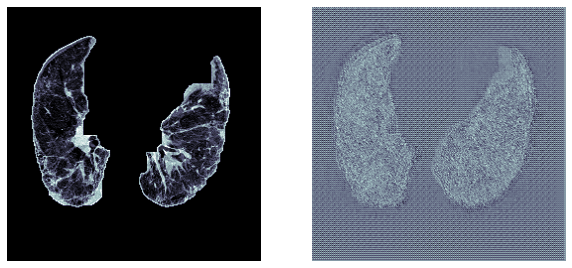

Latent features: [0.0, 0.048780497163534164, 3.371015191078186e-05, 0.0, 0.0, 0.006738042924553156, 0.01953393593430519, 0.039357371628284454, 0.08218389749526978, 0.0] 
Loss: 0.031824701942554004


In [25]:
slc = 0.5
sample_id = np.random.randint(len(data))
print(f'Inspecting CT Scan {data[sample_id]["patient_id"]}')

fig, axs = plt.subplots(1, 2, figsize=(10, 7))

sample = data[sample_id]['image'].squeeze(0).numpy()
axs[0].imshow(sample[int(40 * slc), :, :], cmap=cm.bone)
axs[0].axis('off')
imageio.mimsave("sample_input.gif", sample, duration=0.0001)

with torch.no_grad():
    img = data[sample_id]['image'].unsqueeze(0).float().to(device)
    latent_features = model.encode(img, return_partials=False)\
        .squeeze().cpu().numpy().tolist()
    outputs = model(img).squeeze().cpu().numpy()

axs[1].imshow(outputs[int(40 * slc), :, :], cmap=cm.bone)
axs[1].axis('off')

imageio.mimsave("sample_output.gif", outputs, duration=0.0001)

rmse = ((sample - outputs)**2).mean()
plt.show()
print(f'Latent features: {latent_features} \nLoss: {rmse}')

In [26]:
from IPython.display import HTML
HTML('<br/><img src="https://i.ibb.co/gFxgRq6/sample-input.gif" style="float: left; width: 30%; margin-right: 1%; margin-bottom: 0.5em;">'
     '<img src="https://i.ibb.co/Jm57fWw/sample-output.gif" style="float: left; width: 30%; margin-right: 1%; margin-bottom: 0.5em;">'
     '<p style="clear: both;">')

# 7. Next steps
- Train longer: 10 epochs is not enough to achieve good results
- Use the latent features in the Quant Model, and check how much they improve the predictions
- Investigate/debug why some of the latent features are zero